# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

## Setup Google Colab

In [1]:
# Google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


tcmalloc: large alloc 1073750016 bytes == 0x5882e000 @  0x7fbaf30a22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
# Get the platform details. 
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

from psutil import *
print("cpu_count() =", cpu_count())

# n1-highmem-2 instance
# 2vCPU @ 2.2GHz
# 13GB RAM
# 33GB Free Space
# idle cut-off 90 minutes
# maximum 12 hours

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   19G  322G   6% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G  8.0K  6.4G   1% /var/colab
/dev/sda1       365G   22G  344G   6% /opt/bin
shm             6.0G     0  6.0G   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx 

In [3]:
# (re)install specific version of Pillow ???

#!pip install --no-cache-dir -I pillow
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
#!pip install Pillow

!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.5MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.


## Download the data

In [0]:
# Download the cat/folder to flower name map dict.

!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# Data option 1 - Download train + validation data

#!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
#!rm -rf flower_data
#!unzip -o -qq flower_data.zip

In [0]:
# Data option 2 - Download train + validation + testing data

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!rm -rf flower_data
!mkdir flower_data
!tar -xzf "flower_data.tar.gz" --directory flower_data


In [0]:
# Correct misslabelled valid data.
!mv flower_data/valid/93/image_07303.jpg flower_data/valid/94
!mv flower_data/valid/96/image_07677.jpg flower_data/valid/97

In [0]:
# Correct misslabelled test data.
!mv flower_data/test/96/image_07683.jpg flower_data/test/97
!mv flower_data/test/96/image_07676.jpg flower_data/test/97

## Imports

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML, display

import random
import time
import datetime
import math
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler

import PIL

print("PIL.PILLOW_VERSION =", PIL.PILLOW_VERSION)

# check if CUDA is available
cuda_is_available = torch.cuda.is_available()

if cuda_is_available:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

print(torch.__version__)

print("torch.backends.cudnn.version() =",torch.backends.cudnn.version())
print("torch.backends.cudnn.enabled =",torch.backends.cudnn.enabled)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


PIL.PILLOW_VERSION = 4.0.0
CUDA is not available.
0.4.1
torch.backends.cudnn.version() = 7104
torch.backends.cudnn.enabled = True
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

import random

# Fix the random seeds to allow reproducable results - See https://pytorch.org/docs/stable/notes/randomness.html
seed_number = 9876543

random.seed(seed_number + 0)
np.random.seed(seed_number + 2)
torch.manual_seed(seed_number + 4)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def _init_fn(worker_id):
    np.random.seed(seed_number + worker_id*2 + 6)
    random.seed(seed_number + worker_id*2 + 6)
    

In [0]:
# _init_fn for dataloader workers when not running the above 'fixed seed' cell.
# def _init_fn(worker_id):
#    pass


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
SMALL_SIZE = 24
MEDIUM_SIZE = 30
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


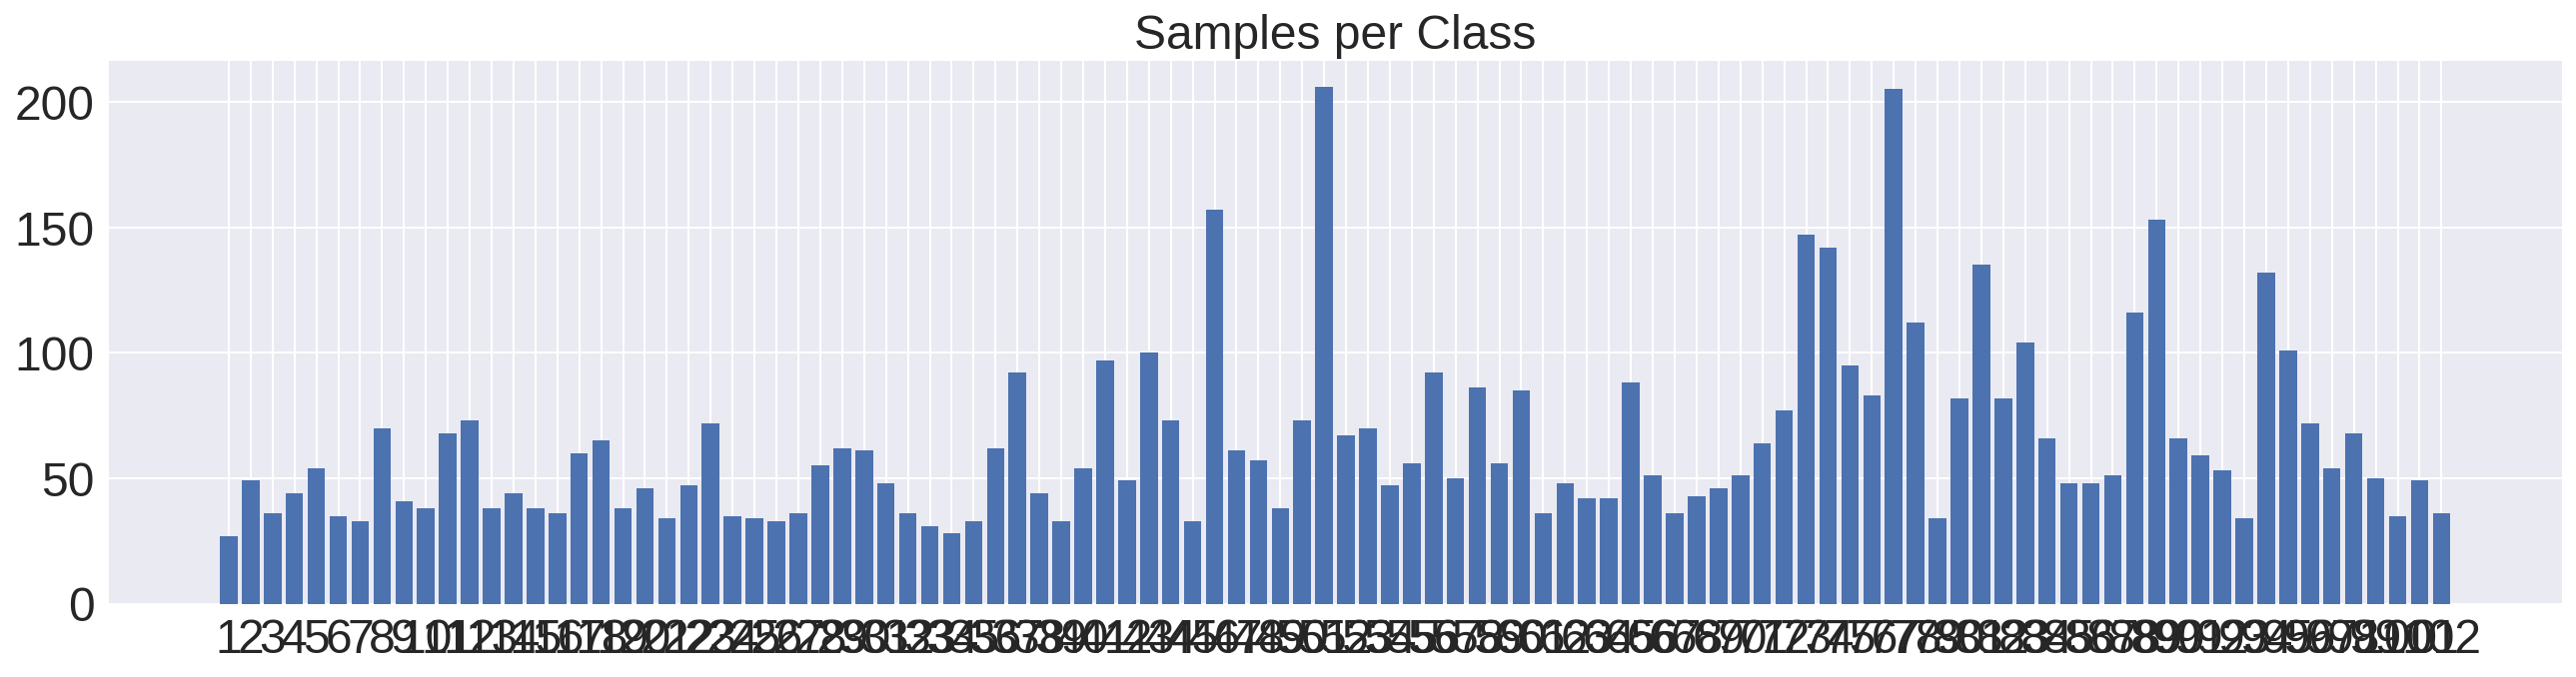

In [13]:
# Class balance check
import os

class_sample_counts = {}

for c in range(1, 103):
    l = class_sample_counts.get(c, 0)
    class_sample_counts[c] = l + len(os.listdir(train_dir + '/' + str(c)))

# Plot showing the class imbalance
plt.figure(figsize=(22, 5))    
plt.bar(range(len(class_sample_counts)), list(class_sample_counts.values()), align='center')
plt.xticks(range(len(class_sample_counts)), list(class_sample_counts.keys()))
plt.title('Samples per Class')
plt.show()

### Find avr and std of datasets

In [0]:
batch_size = 32

data_transforms = {'train': transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ]),
                   'valid': transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ])}
                   
image_datasets = {'train': ImageFolderWithPaths(train_dir, transform=data_transforms['train']),
                  'valid': ImageFolderWithPaths(valid_dir, transform=data_transforms['valid'])}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn)}


In [0]:
# Process test data (if available).

data_transforms['test'] = transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ])
                   
image_datasets['test'] = ImageFolderWithPaths(test_dir, transform=data_transforms['test'])

dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn)


In [0]:

dataloader = dataloaders['train']  # Calc mean and std dev on valid dataset.

num_batches = len(dataloader)
num_images = len(dataloader.dataset)

print("num_images =", num_images)

sum_R = 0.0
sum_G = 0.0
sum_B = 0.0

# MEAN 
for batch_idx, (images, labels, paths) in enumerate(dataloader):
    for image in images:
        numpy_image = image.numpy()
        
        sum_R += np.mean(numpy_image[0, :, :])
        sum_G += np.mean(numpy_image[1, :, :])
        sum_B += np.mean(numpy_image[2, :, :])
        
        
mean_R = sum_R / num_images
mean_G = sum_G / num_images
mean_B = sum_B / num_images

print("mean_R =", mean_R)
print("mean_G =", mean_G)
print("mean_B =", mean_B)

variance_sum_R = 0.0
variance_sum_G = 0.0
variance_sum_B = 0.0

# STD
for batch_idx, (images, labels, paths) in enumerate(dataloader):
    for image in images:
        numpy_image = image.numpy()
        
        variance_sum_R += np.mean(np.square(numpy_image[0, :, :] - mean_R))
        variance_sum_G += np.mean(np.square(numpy_image[1, :, :] - mean_G))
        variance_sum_B += np.mean(np.square(numpy_image[2, :, :] - mean_B))


std_R = math.sqrt(variance_sum_R / num_images)
std_G = math.sqrt(variance_sum_G / num_images)
std_B = math.sqrt(variance_sum_B / num_images)

print("std_R =", std_R)
print("std_G =", std_G)
print("std_B =", std_B)


# ImageNet:
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

# train:
# mean = np.array([0.4783355615295638, 0.39517752961193064, 0.30866970660825066])
# std = np.array([0.29812701159222493, 0.2466230988873886, 0.2773223169309065])

# valid:
# mean = np.array([0.5171494197765306, 0.41370686248837446, 0.336242575546804])
# std = np.array([0.2969178256287961, 0.24609186586075008, 0.28759060707293915])

# test:
# mean = np.array([0.5196253623681482, 0.41152201558580404, 0.332162584188384])
# std = np.array([0.2963379335914937, 0.25203865339538956, 0.2842249256256175])



In [0]:
# norm_mean = [0.485, 0.456, 0.406]
# norm_std = [0.229, 0.224, 0.225]

norm_mean = [0.5178361839861569, 0.4106749456881299, 0.32864167836880803]
norm_std = [0.2972239085211309, 0.24976049135203868, 0.28533308036347665]

### Train + Validation Data

In [0]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses   
    
    # Counts per label
    for item in images:                                                         
        count[item[1]] += 1                                                     
    
    weight_per_class = [0.] * nclasses
    
    # Total number of images.
    N = float(sum(count))                                                   
    
    # super-sample the smaller classes.
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    
    weight = [0] * len(images)                                              
    
    # Calculate a weight per image.
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    
    return weight                                                               

In [0]:
# Using the image datasets and the trainforms, define the dataloaders
batch_size = 32

# Transforms for the training and validation sets
data_transforms = {'train': transforms.Compose([# transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                # transforms.CenterCrop(224),
                                                #===
    
                                                # transforms.RandomResizedCrop(224, 
                                                #                              # scale=(0.75, 1.0), ratio=(1.0, 1.0), 
                                                #                              interpolation=PIL.Image.BILINEAR),
                                                transforms.RandomAffine(45, translate=(0.4, 0.4), scale=(0.75, 1.5), shear=None, resample=PIL.Image.BILINEAR, fillcolor=0),
                                                transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                
                                                # transforms.RandomHorizontalFlip(),
                                                # transforms.RandomVerticalFlip(),
                                                # transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.0, hue=0.1),
                                                # transforms.ColorJitter(brightness=0.025, contrast=0.0, saturation=0.0, hue=0.025),
                                                # transforms.RandomGrayscale(p=0.3),
                                                # transforms.RandomRotation(45.0, resample=PIL.Image.BILINEAR),
                                                #===
                                                # transforms.Grayscale(num_output_channels=3),
                                                transforms.ToTensor(),
                                                transforms.Normalize(norm_mean, norm_std),
                                               ]),
                   'valid': transforms.Compose([# transforms.RandomRotation(45, resample=PIL.Image.BILINEAR),
                                                transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                # transforms.RandomHorizontalFlip(),
                                                #===
                                                #===
                                                # transforms.Grayscale(num_output_channels=3),
                                                transforms.ToTensor(),
                                                transforms.Normalize(norm_mean, norm_std),
                                               ])}

                   
# Load the datasets with ImageFolder
image_datasets = {'train': ImageFolderWithPaths(train_dir, transform=data_transforms['train']),
                  'valid': ImageFolderWithPaths(valid_dir, transform=data_transforms['valid'])}

weights = make_weights_for_balanced_classes(image_datasets['train'].imgs, len(image_datasets['train'].classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
  
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler = sampler, num_workers=5, worker_init_fn=_init_fn),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn)}

### Test Data (if available)

In [0]:
data_transforms['test'] = transforms.Compose([# transforms.RandomRotation(45, resample=PIL.Image.BILINEAR),
                                              transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                              transforms.CenterCrop(224),
                                              # transforms.RandomHorizontalFlip(),
                                              #===
                                              #===
                                              # transforms.Grayscale(num_output_channels=3),
                                              transforms.ToTensor(),
                                              transforms.Normalize(norm_mean, norm_std),
                                             ])

# Load the datasets with ImageFolder
image_datasets['test'] = ImageFolderWithPaths(test_dir, transform=data_transforms['test'])

dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn)

### Create train_dataset_super

In [0]:
# Make one COMBINED training dataset from train & valid datasets (used for experimentation)

# super_train_dataset_dict = {
#    'train': ImageFolderWithPaths(train_dir, transform=data_transforms['train']),
#    'valid': ImageFolderWithPaths(valid_dir, transform=data_transforms['train']),
#    # 'test': ImageFolderWithPaths(test_dir, transform=data_transforms['train'])
#}

#super_train_dataset = torch.utils.data.ConcatDataset(
#    [
#        super_train_dataset_dict['train'],
#        super_train_dataset_dict['valid'],
#        # super_train_dataset_dict['test'],
#    ]
#)

#super_train_dataloader = torch.utils.data.DataLoader(super_train_dataset, batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn)


## Visually inspect the training data.

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow_numpy(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
        
    ax.grid(False)

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(norm_mean)
    std = np.array(norm_std)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

Check that the loaded data looks ok.

In [19]:
print("len(dataloaders['train'].dataset) =", len(dataloaders['train'].dataset))
print("len(dataloaders['valid'].dataset) =", len(dataloaders['valid'].dataset))

len(dataloaders['train'].dataset) = 6552
len(dataloaders['valid'].dataset) = 818


In [20]:
print("len(dataloaders['test'].dataset) =", len(dataloaders['test'].dataset))

len(dataloaders['test'].dataset) = 819


('flower_data/train/26/image_06507.jpg', 'flower_data/train/85/image_04778.jpg', 'flower_data/train/94/image_07305.jpg', 'flower_data/train/43/image_02332.jpg', 'flower_data/train/37/image_03766.jpg', 'flower_data/train/51/image_03948.jpg', 'flower_data/train/76/image_02506.jpg', 'flower_data/train/41/image_02250.jpg', 'flower_data/train/74/image_01289.jpg', 'flower_data/train/24/image_08051.jpg', 'flower_data/train/89/image_00744.jpg', 'flower_data/train/41/image_02295.jpg', 'flower_data/train/13/image_05780.jpg', 'flower_data/train/31/image_06918.jpg', 'flower_data/train/34/image_06962.jpg', 'flower_data/train/82/image_01613.jpg', 'flower_data/train/9/image_06405.jpg', 'flower_data/train/58/image_02662.jpg', 'flower_data/train/84/image_02629.jpg', 'flower_data/train/47/image_05008.jpg', 'flower_data/train/89/image_00713.jpg', 'flower_data/train/83/image_01754.jpg', 'flower_data/train/2/image_05114.jpg', 'flower_data/train/79/image_06705.jpg', 'flower_data/train/72/image_03623.jpg', '

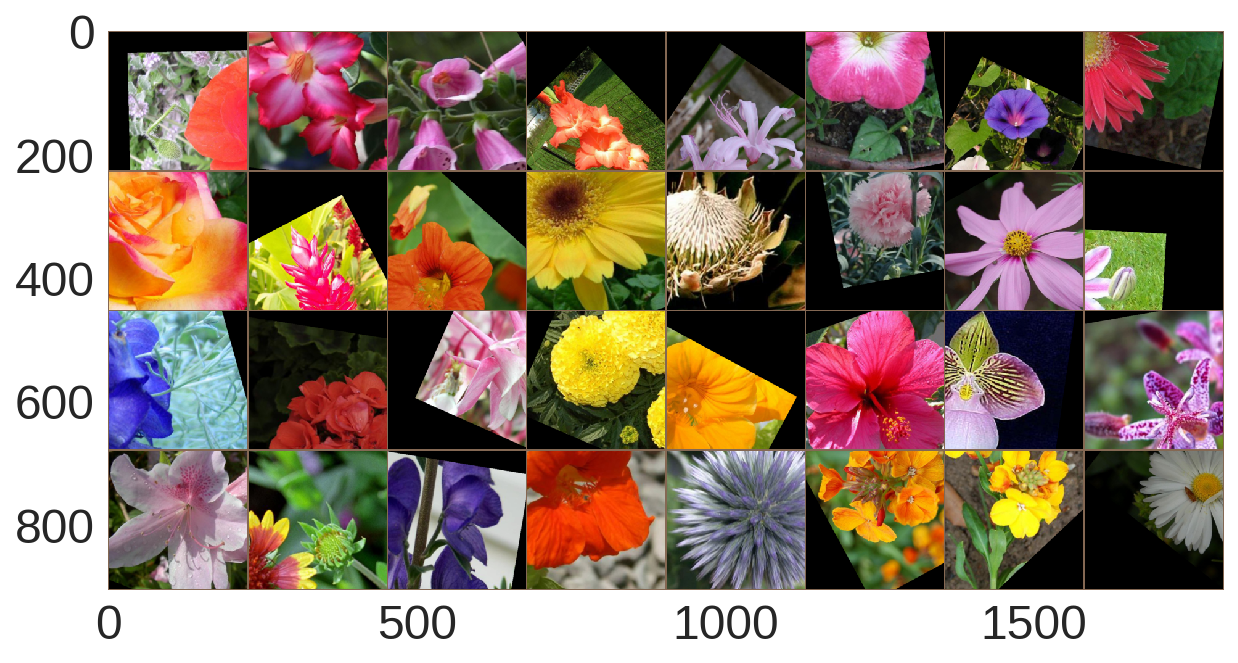

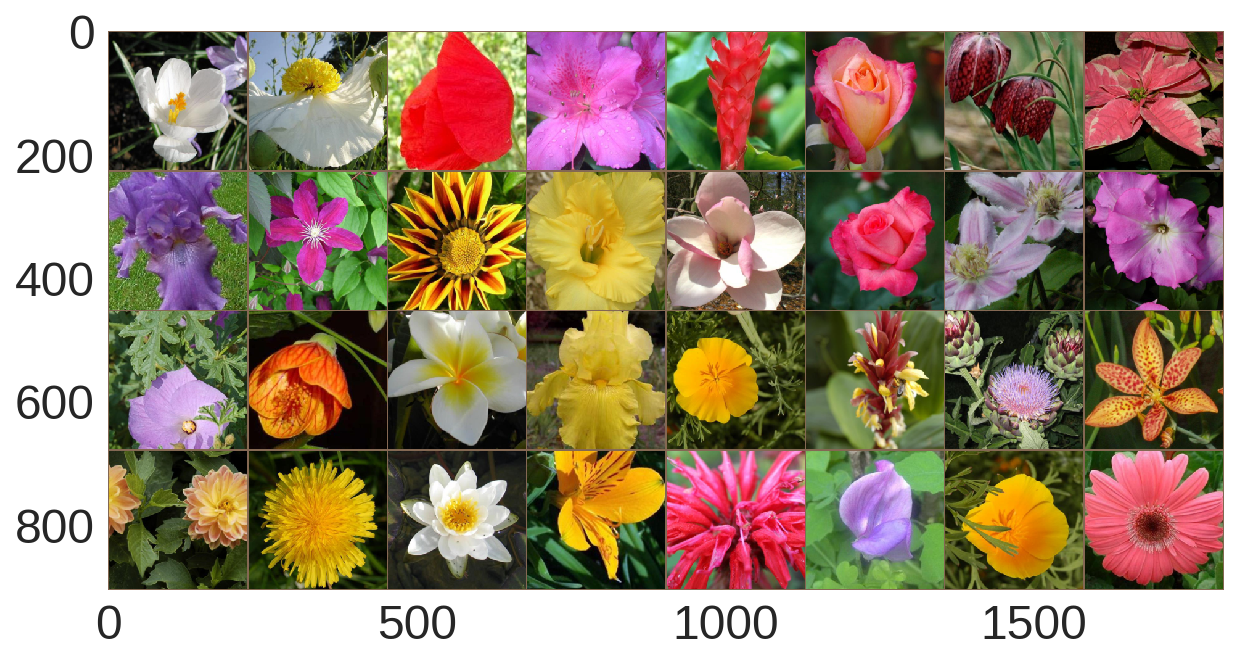

In [21]:
images, labels, paths = next(iter(dataloaders['train']))
grid_images = utils.make_grid(images)                            
print(paths)
imshow_numpy(grid_images.numpy())


images, labels, paths = next(iter(dataloaders['valid']))
grid_images = utils.make_grid(images)                            
print(paths)
imshow_numpy(grid_images.numpy())



('flower_data/test/83/image_01805.jpg', 'flower_data/test/65/image_03197.jpg', 'flower_data/test/87/image_05485.jpg', 'flower_data/test/51/image_03980.jpg', 'flower_data/test/28/image_05214.jpg', 'flower_data/test/61/image_06271.jpg', 'flower_data/test/19/image_06159.jpg', 'flower_data/test/56/image_02779.jpg', 'flower_data/test/33/image_06478.jpg', 'flower_data/test/18/image_04292.jpg', 'flower_data/test/11/image_03177.jpg', 'flower_data/test/78/image_01874.jpg', 'flower_data/test/95/image_07468.jpg', 'flower_data/test/86/image_02910.jpg', 'flower_data/test/90/image_04431.jpg', 'flower_data/test/72/image_03593.jpg', 'flower_data/test/101/image_07949.jpg', 'flower_data/test/82/image_01685.jpg', 'flower_data/test/81/image_00815.jpg', 'flower_data/test/74/image_01249.jpg', 'flower_data/test/13/image_05787.jpg', 'flower_data/test/41/image_02193.jpg', 'flower_data/test/14/image_06083.jpg', 'flower_data/test/9/image_06413.jpg', 'flower_data/test/50/image_06541.jpg', 'flower_data/test/34/ima

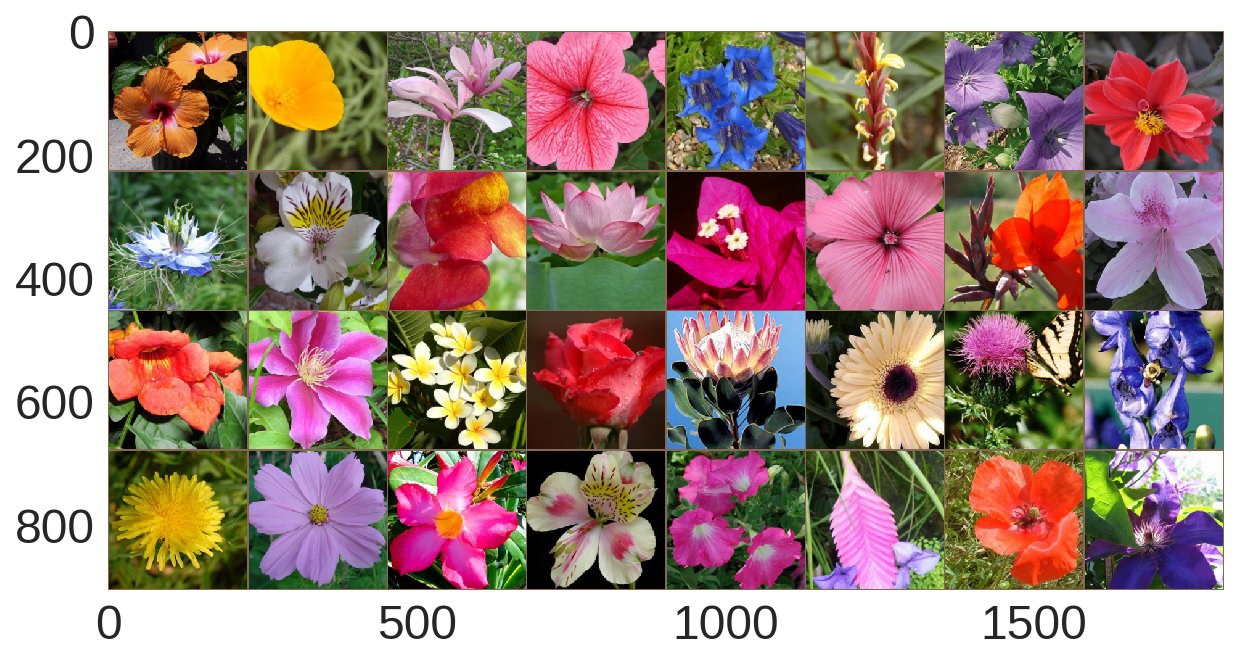

In [22]:

images, labels, paths = next(iter(dataloaders['test']))
grid_images = utils.make_grid(images)                            
print(paths)
imshow_numpy(grid_images.numpy())



### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

## Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:

def progress_bar(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

  
valid_loss_min_A = np.Inf
valid_acc_max_A = 0

valid_loss_min_B = np.Inf
valid_acc_max_B = 0

train_losses, valid_losses = [], []


In [0]:

class FFClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        return x      
      
      
def save_checkpoint(checkpoint_path, model):
    checkpoint = {
        "class_to_idx": model.class_to_idx,        
        "idx_to_class": model.idx_to_class,        
        "cat_to_name": model.cat_to_name,        
        "state_dict": model.state_dict()
    }
    
    torch.save(checkpoint, checkpoint_path)
    
    
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    model = models.resnet152(pretrained=False)
    
    for param in model.parameters():
       param.requires_grad = False

    # Put the classifier on the pretrained network
    model.fc = FFClassifier(2048, 102)

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint["class_to_idx"]
    model.idx_to_class = checkpoint["idx_to_class"]
    model.cat_to_name = checkpoint["cat_to_name"]
        
    return model


## Creating and training the model

**Create and Train** - Run steps 1 to 5 below.

**Warm restart** - Re-run steps 2, 3 and 5 as many times as required.

### 1. Create the model

In [25]:
# Load pretrained model.
model = models.resnet152(pretrained=True)
model_requires_grad_params = []

# Freeze parameters so we don't backprop through them
for param in model.parameters():
  if param.requires_grad == True:
      # param.requires_grad = False
      model_requires_grad_params.append(param)      

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 85670994.06it/s]


In [0]:
model.fc = FFClassifier(2048, 102)


### 2. Set/Reset loss function and optimizer

In [27]:
if cuda_is_available:
    model.cuda()
    
num_epochs = 20
        
# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

optimizer = optim.Adam(
    [
        {'params': model.conv1.parameters(),  'lr': 0.000001},
        {'params': model.layer1.parameters(), 'lr': 0.000001},
        {'params': model.layer2.parameters(), 'lr': 0.00001},
        {'params': model.layer3.parameters(), 'lr': 0.00001},
        {'params': model.layer4.parameters(), 'lr': 0.0001},
        {'params': model.fc.parameters(),     'lr': 0.001}
    ], lr=0.0, weight_decay=0.001)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30, 40], gamma=0.3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for idx, param_group in enumerate(optimizer.param_groups):
    print(idx, param_group['lr'])

0 1e-06
1 1e-06
2 1e-05
3 1e-05
4 0.0001
5 0.001


### 3. Define the train() function. Trains and validates the model over n_epochs.

In [0]:
def train(n_epochs = 10, manual_lrs = None, run_schedular = True):
    # Need access to some global notebook variables...
    global valid_loss_min_A
    global valid_acc_max_A
    global valid_loss_min_B
    global valid_acc_max_B    
    global train_losses
    global valid_losses

    # Update the param group learning rates if supplied.
    if manual_lrs is not None:
        for idx, param_group in enumerate(optimizer.param_groups):
            param_group['lr'] = manual_lrs[idx]

    for epoch in range(1, n_epochs+1):
        print("Epoch {}".format(epoch))
                
        if run_schedular:
            scheduler.step()

        max_lr = 0.0  # max current lr over param groups.

        for param_group in optimizer.param_groups:
            if param_group['lr'] > max_lr:
              max_lr = param_group['lr']

        print("max_lr = {}".format(max_lr))
        
        # print("LRs", scheduler.get_lr())

        train_loss_sum = 0.0
        valid_loss_sum = 0.0
        train_correct_count = 0.0
        valid_correct_count = 0.0

        
        ##############################################
        # Choose the training and validation datasets.
        
        train_dataloader = dataloaders['train']
        # train_dataloader = super_train_dataloader

        valid_dataloader = dataloaders['valid']
        # valid_dataloader = dataloaders['test']
        ##############################################


        ###################
        # train the model #
        ###################
        print("Training...")

        training_start_time = time.time()
        train_display = display(progress_bar(0, 100), display_id=True)
        model.train()    
        
        num_batches = math.ceil(len(train_dataloader.dataset) / batch_size)

        for batch_idx, (images, labels, paths) in enumerate(train_dataloader):
            # labels are the integer indexes of the class/folder names.

            if cuda_is_available:
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(images)  # batch_size x 102
                loss = criterion(outputs, labels)  # Average loss value over batch.
                loss.backward()
                optimizer.step()

            train_loss_sum += loss.item() * images.size(0)  

            _, predicted_labels = torch.max(outputs, -1)
            train_correct_count += (predicted_labels == labels).double().sum().item()   

            progress = (batch_idx+1) * 100.0 / num_batches        
            train_display.update(progress_bar(progress, 100))


        ######################    
        # validate the model #
        ######################
        print("Validating...")

        validation_start_time = time.time()
        valid_display = display(progress_bar(0, 100), display_id=True)
        model.eval()    
        
        num_batches = math.ceil(len(valid_dataloader.dataset) / batch_size)

        for batch_idx, (images, labels, paths) in enumerate(valid_dataloader):
            if cuda_is_available:
                images, labels = images.cuda(), labels.cuda()

            with torch.set_grad_enabled(False):
                outputs = model(images)  # batch_size x 102
                loss = criterion(outputs, labels)  # Average loss value over batch.

            valid_loss_sum += loss.item() * images.size(0)

            _, predicted_labels = torch.max(outputs, -1)
            valid_correct_count += (predicted_labels == labels).double().sum().item()

            progress = (batch_idx+1) * 100.0 / num_batches
            valid_display.update(progress_bar(progress, 100))


        epoch_end_time = time.time()

        ############################
        # calculate average losses #
        ############################
        train_loss = train_loss_sum / len(train_dataloader.dataset)
        valid_loss = valid_loss_sum / len(valid_dataloader.dataset)
        train_acc = train_correct_count / len(train_dataloader.dataset)
        valid_acc = valid_correct_count / len(valid_dataloader.dataset)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)


        #if run_schedular:
        #    scheduler.step(valid_loss)

            
        print('Training Loss={:.6f}  Training Accuracy={:.6f}  Duration={:.2f}'.format(train_loss, 
                                                                                       train_acc, 
                                                                                       validation_start_time - training_start_time))  

        print('Validation Loss={:.6f}  Validation Accuracy={:.6f}  Duration={:.2f}'.format(valid_loss, 
                                                                                           valid_acc, 
                                                                                           epoch_end_time - validation_start_time))


        if (valid_loss < valid_loss_min_A) or ((valid_loss == valid_loss_min_A) and (valid_acc >= valid_acc_max_A)):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min_A, valid_loss))
            torch.save(model.state_dict(), 'state_dict_best_valid_loss.pt')
            valid_loss_min_A = valid_loss
            valid_acc_max_A = valid_acc

            
        if (valid_acc > valid_acc_max_B) or ((valid_acc == valid_acc_max_B) and (valid_loss <= valid_loss_min_B)):
            print('Validation acc increased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_acc_max_B, valid_acc))
            torch.save(model.state_dict(), 'state_dict_best_valid_acc.pt')
            valid_loss_min_B = valid_loss
            valid_acc_max_B = valid_acc


        print()

### 4. Train the classifier only.

In [0]:
# Freeze the earlier layers of the pre-trained network.
for param in model_requires_grad_params:
  param.requires_grad = False

# Set smaller learning rates for the earlier layers of the model.
manual_lrs = [0.000001, 
              0.000001, 
              0.00001, 
              0.00001, 
              0.0001, 
              0.001]

train(20, manual_lrs, False)


Epoch 1
max_lr = 0.001
Training...


Validating...


Training Loss=2.566799  Training Accuracy=0.500305  Duration=146.60
Validation Loss=1.099579  Validation Accuracy=0.764059  Duration=17.47
Validation loss decreased (inf --> 1.099579).  Saving model ...
Validation acc increased (0.000000 --> 0.764059).  Saving model ...

Epoch 2
max_lr = 0.001
Training...


Validating...


Training Loss=1.032763  Training Accuracy=0.789072  Duration=146.59
Validation Loss=0.553097  Validation Accuracy=0.877751  Duration=17.93
Validation loss decreased (1.099579 --> 0.553097).  Saving model ...
Validation acc increased (0.764059 --> 0.877751).  Saving model ...

Epoch 3
max_lr = 0.001
Training...


Validating...


Training Loss=0.732433  Training Accuracy=0.838370  Duration=150.93
Validation Loss=0.414550  Validation Accuracy=0.896088  Duration=17.39
Validation loss decreased (0.553097 --> 0.414550).  Saving model ...
Validation acc increased (0.877751 --> 0.896088).  Saving model ...

Epoch 4
max_lr = 0.001
Training...


Validating...


Training Loss=0.601793  Training Accuracy=0.858822  Duration=147.56
Validation Loss=0.339692  Validation Accuracy=0.918093  Duration=17.30
Validation loss decreased (0.414550 --> 0.339692).  Saving model ...
Validation acc increased (0.896088 --> 0.918093).  Saving model ...

Epoch 5
max_lr = 0.001
Training...


In [0]:
# Load the model that resulted in the lowest error to maybe or the highest validation accuract

model.load_state_dict(torch.load('state_dict_best_valid_loss.pt'))  # B
# model.load_state_dict(torch.load('state_dict_best_valid_acc.pt'))  # C

### 5. Train/finetune the entire model

In [0]:
# UN-Freeze the earlier layers of the pre-trained network!
for param in model_requires_grad_params:
  param.requires_grad = True

# Set smaller learning rates for the earlier layers of the model.
manual_lrs = [0.000001, 
              0.000001, 
              0.00001, 
              0.00001, 
              0.0001, 
              0.001]

train(num_epochs, manual_lrs, True)


### Graph the training and validation losses over the epochs.

In [0]:
plt.figure(figsize=(20,10))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

### Load BEST model

In [0]:
# Load the model that resulted in the lowest error to maybe or the highest validation accuract

model.load_state_dict(torch.load('state_dict_best_valid_loss.pt'))  # B
# model.load_state_dict(torch.load('state_dict_best_valid_acc.pt'))  # C

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}

In [0]:
# idx is the same as the label.
# class is the folder name ['1'...'102']

model.class_to_idx = image_datasets['train'].class_to_idx
model.idx_to_class = idx_to_class
model.cat_to_name = cat_to_name

# Save the checkpoint 
save_checkpoint('model_checkpoint.pt', model)

# Also save to gdrive.
ts = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
save_checkpoint('/content/gdrive/My Drive/model_checkpoint_B_'+str(ts)+'.pt', model)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
model = load_checkpoint('model_checkpoint.pt')

In [0]:
# model.cpu()


## Test the loaded model with validation data set

In [0]:
valid_loss_sum = 0.0
valid_correct_count = 0.0

######################    
# validate the model #
######################
validation_start_time = time.time()
print("Validating...")
valid_display = display(progress_bar(0, 100), display_id=True)

model.eval()    

if cuda_is_available:
    model.cuda()

num_batches = math.ceil(len(dataloaders['valid'].dataset) / batch_size)

for batch_idx, (images, labels, paths) in enumerate(dataloaders['valid']):

    if cuda_is_available:
        images, labels = images.cuda(), labels.cuda()

    with torch.set_grad_enabled(False):
        outputs = model(images)  # batch_size x 102
        loss = criterion(outputs, labels)  # Average loss value over batch.

    valid_loss_sum += loss.item() * images.size(0)

    _, predicted_labels = torch.max(outputs, -1)
    valid_correct_count += (predicted_labels == labels).double().sum().item()
        
    for i in range(len(labels.data)):
        if labels[i] != predicted_labels[i]:
            print(paths[i], " truth =", idx_to_class[labels[i].item()]," predicted =", idx_to_class[predicted_labels[i].item()])

    progress = (batch_idx+1) * 100.0 / num_batches
    valid_display.update(progress_bar(progress, 100))


validation_end_time = time.time()

############################
# calculate average losses #
############################
valid_loss = valid_loss_sum / len(dataloaders['valid'].dataset)
valid_acc = valid_correct_count / len(dataloaders['valid'].dataset)

print('Validation Loss={:.6f}  Validation Accuracy={:.6f}  Duration={:.2f}'.format(valid_loss, 
                                                                                   valid_acc, 
                                                                                   validation_end_time - validation_start_time))



## Test the loaded model with testing set

In [0]:
test_loss_sum = 0.0
test_correct_count = 0.0

##################    
# test the model #
##################
testing_start_time = time.time()
print("Testing...")
test_display = display(progress_bar(0, 100), display_id=True)

model.eval()   

if cuda_is_available:
    model.cuda()

num_batches = math.ceil(len(dataloaders['test'].dataset) / batch_size)

for batch_idx, (images, labels, paths) in enumerate(dataloaders['test']):

    if cuda_is_available:
        images, labels = images.cuda(), labels.cuda()

    with torch.set_grad_enabled(False):
        outputs = model(images)  # batch_size x 102
        loss = criterion(outputs, labels)  # Average loss value over batch.

    test_loss_sum += loss.item() * images.size(0)

    _, predicted_labels = torch.max(outputs, -1)
    test_correct_count += (predicted_labels == labels).double().sum().item()

    for i in range(len(labels.data)):
        if labels[i] != predicted_labels[i]:
            print(paths[i], " truth =", idx_to_class[labels[i].item()]," predicted =", idx_to_class[predicted_labels[i].item()])

    progress = (batch_idx+1) * 100.0 / num_batches
    test_display.update(progress_bar(progress, 100))


testing_end_time = time.time()

############################
# calculate average losses #
############################
test_loss = test_loss_sum / len(dataloaders['test'].dataset)
test_acc = test_correct_count / len(dataloaders['test'].dataset)

print('Testing Loss={:.6f}  Testing Accuracy={:.6f}  Duration={:.2f}'.format(test_loss, 
                                                                             test_acc, 
                                                                             testing_end_time - testing_start_time))



Testing...


flower_data/test/21/image_06805.jpg  truth = 21  predicted = 84
flower_data/test/40/image_04568.jpg  truth = 40  predicted = 84
flower_data/test/4/image_05653.jpg  truth = 4  predicted = 9
flower_data/test/50/image_06297.jpg  truth = 50  predicted = 12
Testing Loss=0.026481  Testing Accuracy=0.995116  Duration=18.50


##Airtable Test

In [0]:
# https://medium.com/@ml_kid/a-test-rubric-for-the-final-project-87db6a4480ea OORRRR
##
# https://github.com/GabrielePicco/deep-learning-flower-identifier

!git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
!pip install requests
!pip install airtable

import sys
sys.path.insert(0, 'deep-learning-flower-identifier')
from test_model_pytorch_facebook_challenge import calc_accuracy

# model = load_your_model('classifier.pth')
calc_accuracy(model, input_image_size=224, use_google_testset=False, norm_mean=norm_mean, norm_std=norm_std)

Cloning into 'deep-learning-flower-identifier'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 74 (delta 42), reused 29 (delta 4), pack-reused 0
Unpacking objects: 100% (74/74), done.
  Running setup.py bdist_wheel for airtable ... - done
  Stored in directory: /root/.cache/pip/wheels/9b/ba/63/364c02fabcd50ef6e2f101a57feb727bd7a693697765a9df17
Successfully built airtable


100.0% 35053568 / 35050314


Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Mean accuracy: 0.9927884340286255


0.99278843

In [0]:
from test_model_pytorch_facebook_challenge import publish_evaluated_model
publish_evaluated_model(model, input_image_size=224,  
                        use_google_testset=False, norm_mean=norm_mean, norm_std=norm_std,
                        username="@Bernardt Duvenhage", 
                        model_name="Resnet152", optim="Adam",
                        criteria="NLLLoss", scheduler="Manual adjustment, ReduceLROnPlateau", epoch=80)

Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Mean accuracy: 0.9915865659713745

Previous model was better: Accuracy on test set was 0.99519230, now is 0.9915866255760193


## Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

### Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    w,h = image.size    

    if w < h:
      resize_w = 256
      resize_h = round(h/w * 256)
    else:
      resize_w = round(w/h * 256)
      resize_h = 256
      
    # Convert to three channel grayscale.
    #image = image.convert('L', (0.33, 0.33, 0.33, 0))
    #image = image.convert('RGB')
    
    # resize smallest dimension to be 256.
    image = image.resize((resize_w, resize_h), PIL.Image.BILINEAR)
    
    if resize_w<224:
        print("resize_w =", resize_w)
    if resize_h<224:
        print("resize_h =", resize_h)
    
    # crop to 224 x 224
    image = image.crop((resize_w//2-112, 
                        resize_h//2-112, 
                        resize_w//2+112, 
                        resize_h//2+112))

    np_image = np.array(image, np.float32)

    np_image /= 255.0
    np_image -= norm_mean
    np_image /= norm_std

    return np_image.transpose(2,0,1)
 

In [0]:
# Test process_image(...)
pil_image = PIL.Image.open("flower_data/train/1/image_06734.jpg")

np_image = process_image(pil_image)

imshow_numpy(np_image)



### Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model. '''

    model.eval()
    
    pil_image = PIL.Image.open(image_path)
    np_image = process_image(pil_image)    
    torch_image = torch.as_tensor(np_image).view((1,3,224,224))
    
    if cuda_is_available:
        torch_image = torch_image.cuda()    
      
    output = model(torch_image)  
    output_tensor, labels_idx_tensor = output.topk(topk)
    
    output_tensor, labels_idx_tensor = output_tensor.cpu(), labels_idx_tensor.cpu()

    probs = np.exp(output_tensor.view(topk).detach().numpy()).tolist()
    # probs = output_tensor.view(topk).detach().numpy().tolist()

    labels_idx = labels_idx_tensor.view(topk).detach().numpy().tolist()
    
    labels_class = [model.idx_to_class.get(idx, "UNKNOWN") for idx in labels_idx]
    
    return probs, labels_class




In [0]:
# Test predict(...)
image_path = "flower_data/valid/1/image_06749.jpg"

if cuda_is_available:
    model.cuda()

probs, classes = predict(image_path, model, topk=5)

print(probs)
print(classes)


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:


You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# Display an image along with the top 5 classes

def check_sanity(image, probs, classes, cat_to_name):
    """ Takes the numpy image, probs list and labels list and displays all. """
    fig, (ax1, ax2) = plt.subplots(figsize=(9,6), nrows=2)

    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array(norm_mean)
    std = np.array(norm_std)
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax1.set_title(cat_to_name[classes[0]])
    ax1.imshow(image)
    ax1.axis('off')

    ax2.barh(range(len(probs)), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(range(len(probs)))

    ax2.set_yticklabels([cat_to_name[c] for c in classes], size='small');

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.gca().invert_yaxis()
    plt.tight_layout()


In [0]:
pil_image = PIL.Image.open(image_path)
np_image = process_image(pil_image)

check_sanity(np_image, probs, classes, model.cat_to_name)


## Get Kaggle test data

In [0]:
# https://www.kaggle.com/c/oxford-102-flower-pytorch/leaderboard
!cp "/content/gdrive/My Drive/flower_data_all.zip" .
!unzip -o -qq flower_data_all.zip 

In [0]:
!ls flower_data_all

!mkdir kaggle_test_data
!mkdir kaggle_test_data/all

!cp flower_data_all/test/* kaggle_test_data/all

# !ls kaggle_test_data/all

## Create Kaggle submission.csv (Option 1, using ImageFolder)

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [0]:
kaggle_test_dir = "kaggle_test_data"

kaggle_test_dataset = ImageFolderWithPaths(kaggle_test_dir, data_transforms['test'])
kaggle_test_dataloader = torch.utils.data.DataLoader(kaggle_test_dataset, batch_size=batch_size, shuffle=False)


In [0]:
from os import listdir

test_path_base = "flower_data/test"
image_to_class_map = {}

for i in range(102):
    test_path = test_path_base + "/" + str(i + 1)
    test_files = listdir(test_path)

    for test_file in test_files:
        image_to_class_map[test_file] = str(i + 1)
        

In [0]:
import pandas as pd

def kaggle_prep(model, idx_to_class, dataloader):
    
    print("Testing...")
    test_display = display(progress_bar(0, 100), display_id=True)

    model.eval()
    model.cuda()

    image_matches = []
    
    pathstr = "kaggle_test_data/all/"
    
    num_batches = math.ceil(len(dataloader.dataset) / batch_size)
    
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for batch_idx, (data, target, paths) in enumerate(dataloader):
            
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
            _, pred = torch.max(output, 1)
            
            for i in range(len(target.data)):
                file_name = str.replace(paths[i], pathstr, '')
                image_matches.append([file_name, idx_to_class[pred[i].item()]])
                
                if image_to_class_map[file_name] == idx_to_class[pred[i].item()]:
                    correct_count += 1
                else:
                    print(file_name, "truth =", image_to_class_map[file_name]," predicted =", idx_to_class[pred[i].item()])
                total_count += 1
                
            progress = (batch_idx+1) * 100.0 / num_batches
            test_display.update(progress_bar(progress, 100))

    image_matches = pd.DataFrame(image_matches, columns = ["Image", "Prediction"])
    
    print("accuracy =", correct_count/total_count)
    
    return (image_matches)

In [0]:
kaggle_test_images = kaggle_prep(model, idx_to_class, kaggle_test_dataloader);

kaggle_test_images[['Image', 'Prediction']].to_csv('submission_B.csv', header=["file_name","id"], index=False)

!cp submission_B.csv "/content/gdrive/My Drive"

## Create Kaggle submission.csv (Option 2, using process_image)

In [0]:
from os import listdir

test_path = "flower_data_all/test"
test_files = listdir(test_path)

test_result_dict = {}
test_result_list = []

print("Testing...")
valid_display = display(progress_bar(0, 100), display_id=True)

for test_file in test_files:
    image_path = test_path + "/" + test_file
    _, classes = predict(image_path, model, topk=5)
    
    test_result_dict[test_file] = classes[0]  
    test_result_list.append((test_file, classes[0]))

    progress = len(test_result_list) * 100.0 / len(test_files)
    valid_display.update(progress_bar(progress, 100))

print("done.")
print()

# print("Results")
# print(test_result_dict)
# print(test_result_list)

Testing...


done.



In [0]:
import csv

with open('submission_C.csv', mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    submission_writer.writerow(("file_name", "id"))
    
    for row in test_result_list:
        submission_writer.writerow(row)

In [0]:
!cp submission_C.csv "/content/gdrive/My Drive"

In [0]:
%%javascript
IPython.notebook.save_notebook()

In [0]:
while True:
    a = 1

### Test of Kaggle test set quality

In [0]:
from os import listdir

test_path_base = "flower_data/test"
image_to_class_map = {}

for i in range(102):
    test_path = test_path_base + "/" + str(i + 1)
    test_files = listdir(test_path)

    for test_file in test_files:
        image_to_class_map[test_file] = str(i + 1)
        

test_path = "flower_data_all/test"
test_files = listdir(test_path)

test_result_dict = {}
test_result_list = []

for test_file in test_files:
    test_result_dict[test_file] = image_to_class_map[test_file]    
    test_result_list.append((test_file, image_to_class_map[test_file]))


In [0]:
import csv

with open('submission.csv', mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    submission_writer.writerow(("file_name", "id"))
    
    for row in test_result_list:
        submission_writer.writerow(row)
